# Setup

In [3]:
packrat::init(project = "/work/postresearch/Shared/Projects/Farbod/CaseMix")

Initializing packrat project in directory:
- "/work/postresearch/Shared/Projects/Farbod/CaseMix"

Initialization complete!



In [26]:
#packrat::status()


The following packages have been updated in your library, but have not been recorded in packrat:
              library   packrat
    zeallot     0.1.0        NA

Use packrat::snapshot() to record these packages in packrat.


In [4]:
setwd('/work/postresearch/Shared/Projects/Farbod/Integration_Intensity')

In [5]:
options(repr.matrix.max.rows=100, repr.matrix.max.cols=300)
options(repr.plot.width = 20, repr.plot.height = 15)
options(width=300)

numcores=128

library(tidyverse)
library(parallel)
library(data.table)
library(fst)
library(comorbidity)
library(zeallot)
library(reshape)
library(dtplyr)
library(haven)
library(vroom)
library(dplyr)
`%!in%` = Negate(`%in%`)

setDTthreads(numcores)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is {comorbidity} version 1.0.3.

A lot has changed since the pre-1.0.0 release on CRAN, please check-out breaking changes here:

-> https://ellessenne.githu

In [29]:
#diagnosis codes
#from https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleId=52850&ver=26 and https://www.aapc.com/codes/cpt-codes-range/93451-93533/10
angio_codes=c(93451,93452,93453,93454,93455,93456,93457,93458,93459,93460,93461,93462,93463,93464
              ,93503,93505,93530,93531,93532,93533)
#from https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleid=57326&ver=13&keyword=electrocardiogram&keywordType=starts&areaId=all&docType=NCA,CAL,NCD,MEDCAC,TA,MCD,6,3,5,1,F,P&contractOption=all&sortBy=relevance&bc=1
ecg_codes=c(93000,93005,93010,93040,93041,93042)
#from https://scct.org/page/CardiacCTCodes include CTangio
cardiac_ct_codes=c(75571,75572,75573,75574)
#from https://cardiacmri.com/tech-guide/cpt-codes-relevant-to-cardiac-mri/
cardiac_mri_codes=c(75557,75559,75561,75563,75565)
# from https://medicarepaymentandreimbursement.com/2011/07/cardiovascular-stress-testing-cpt-93015.html and https://www.aapc.com/codes/cpt-codes-range/93000-93050/
stress_test_codes=c(93015,93016,93017,93018)
#from https://www.aapc.com/codes/cpt-codes-range/93303-93356/20     includes stress echo
echocardiography_codes=c(93303,93304,93306,93307,93308,93312,93313,93314,93315,93316,93317,93318
                         ,93320,93321,93325,93350,93351,93356,93352,93355,93356)
#from https://www.aapc.com/codes/cpt-codes-range/92920-92979/ and https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleId=57479#:~:text=CPT%20codes%2092928%2C%2092933%2C%2092929,are%20assigned%20to%20APC%200104.    includes balloon and stent
angioplasty_codes=c(92920,92921,92924,92925,92928,92929,92933,92934,92937,92938,92941,92943,92944
                    ,92973,92974,92975,92978,92979,93571,93572,"C9600","C9601","C9602","C9603"
                    ,"C9604","C9605","C9606","C9607","C9608")
#from https://www.medaxiom.com/clientuploads/webcast_handouts/Coding_for_CABG-Open_Heart_Procedures.pdf and https://www.aapc.com/codes/cpt-codes-range/33016-33999/10    did not include 33517-33530 since these are used in conjunction with 33533-33548 and not alone, did not include 33542,33545,33548 since these are also in conjunction )aneurismectomy and vsd resection
CABG_codes=c(33510,33511,33512,33513,33514,33516,33533,33534,33535,33536)
#from http://www.icd9data.com/2015/Volume1/390-459/430-438/default.htm and https://www.icd10data.com/ICD10CM/Codes/I00-I99/I60-I69/I63-
stroke_icd_9_codes=c(43301,43311,43321,43331,43381,43391,43401,43411,43491)
office_visit_codes=c("99201","99202","99203","99204","99205","99211","99212","99213","99214"
                     ,"99215")
IHD_icd_9_codes=c(410, 411, 412,413,414)
IHD_icd_10_codes=c("I20", "I21", "I22", "I23", "I24", "I25")

non_us_state_codes=c(40,54,56,57,58,59,60,61,62,63,64,65,66,97,98,99)

primary_care_specialty_codes=c("01", "08", "11", "38")
surgery_specialty_codes=c("02","04","14","19","20","24","28","33","34","40","48","77","78","85","91")

#http://www.icd9data.com/2015/Volume1/390-459/401-405/default.htm
#https://www.icd10data.com/ICD10CM/Codes/I00-I99/I10-I16
hypertension_icd_9_codes=c("401","402","403","404","405")
hypertension_icd_10_codes=c("I10","I11","I12","I13","I15","I16")

#http://www.icd9data.com/2014/Volume1/460-519/490-496/default.htm
#https://www.icd10data.com/ICD10CM/Codes/J00-J99/J40-J47
copd_icd_9_codes=c("490","491","492","493","494","495","496")
copd_icd_10_codes=c("J40","J41","J42","J43","J44","J45","J47")

#http://www.icd9data.com/2015/Volume1/240-279/270-279/278/278.htm?__hstc=93424706.cdd51240e438a5219319ce13ccb23860.1648603374124.1648603374124.1648607295327.2&__hssc=93424706.9.1648607295327&__hsfp=908776442
#https://www.icd10data.com/ICD10CM/Codes/E00-E89/E65-E68/E66-
obesity_icd_9_codes=c("2780","V853","V854")
obesity_icd_10_codes=c("E660","E669","Z683","Z684")

#http://www.icd9data.com/2014/Volume1/290-319/295-299/296/default.htm
#https://www.icd10data.com/ICD10CM/Codes/F01-F99/F30-F39
depression_icd_9_codes=c("2962","2963")
depression_icd_10_codes=c("F32","F33")

#http://www.icd9data.com/2015/Volume1/240-279/249-259/default.htm
#https://www.icd10data.com/ICD10CM/Codes/E00-E89/E08-E13
diabetes_icd_9_codes=c("250")
diabetes_icd_10_codes=c("E08","E09","E10","E11","E13")

# adding MDPPAS

In [15]:
yearly_calculations=read.csv("./results_july/stable_data_clean.csv")%>%as.data.table()

In [24]:
yearly_calculations[,most_common_cardiologist_PRF_PHYSN_NPI:=as.character(most_common_cardiologist_PRF_PHYSN_NPI)]

In [68]:
head(yearly_calculations)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,

In [13]:
colnames(yearly_calculations)

[1] "X"                                                                                           "DESY_SORT_KEY"                                                                               "first_diagnosis"                                                                            
  [4] "tot_allowed_carrier"                                                                         "office_visit_count"                                                                          "office_visit_cost_carrier"                                                                  
  [7] "cardiology_visit_count"                                                                      "distinct_clinicians"                                                                         "distinct_cardiologists"                                                                     
 [10] "distinct_primary_care_physicians"                                                            "distinct_surgeons"                                                                           "distinct_other_specialties"                                                                 
 [13] "catheterization_count"                                                                       "catheterization_cost_carrier"                                                                "ecg_count"                                                                                  
 [16] "ecg_cost_carrier"                                                                            "cardiac_ct_count"                                                                            "cardiac_ct_cost_carrier"                                                                    
 [19] "cardiac_mri_count"                                                                           "cardiac_mri_cost_carrier"                                                                    "stress_test_count"                                                                          
 [22] "stress_test_cost_carrier"                                                                    "echocardiography_count"                                                                      "echocardiography_cost_carrier"                                                              
 [25] "angioplasty_count"                                                                           "angioplasty_cost_carrier"                                                                    "CABG_count"                                                                                 
 [28] "CABG_cost_carrier"                                                                           "stable_angina"                                                                               "unstable_angina"                                                                            
 [31] "MI"                                                                                          "MI_date"                                                                                     "cardiac_arrest"                                                                             
 [34] "stroke"                                                                                      "hypertension"                                                                                "copd"                                                                                       
 [37] "obesity"                                                                                     "depression"                                                                                  "diabetes"                                                                                   
 [40] "icd_9_pure"                                                                                  "icd_10_pure"                                                                                 "catheterization_date"                                          

## Read from fst

In [4]:
mdppas_data <- read_fst(path = "/work/postresearch/Shared/Data_raw/Medicare/MDPPAS/mdppas.fst", as.data.table = T)

In [5]:
mdppas_data[,npi:=as.character(npi)]

In [6]:
head(mdppas_data)

npi,year,viclaims,vikeyword,tin1_nu,tin1_legal_name,tin2_nu,tin2_legal_name,name_last,name_first,name_middle,SPEC_PRIM_1_NAME,SPEC_PRIM_1,SPEC_BROAD,SEX,SPEC_PRIM_2,SPEC_PRIM_2_NAME,SPEC_SOURCE,SPEC_SOURCE_HOSP,POS_OFFICE,POS_INPAT,POS_OPD,POS_ER,POS_NURSING,POS_ASC,POS_RESID,POS_RETAIL,POS_URGENT,POS_OTHER,STATE,STATE_MULTI,CBSA_TYPE,CBSA_CD,CBSA_NAME,CBSA_MULTI,NPI_SRVC_LINES,NPI_ALLOWED_AMT,NPI_UNQ_BENES,TIN1_SRVC_MONTH,TIN1_SRVC_LINES,TIN1_ALLOWED_AMT,TIN1_UNQ_BENES,TIN2_SRVC_MONTH,TIN2_SRVC_LINES,TIN2_ALLOWED_AMT,TIN2_UNQ_BENES,BIRTH_YR,lns_office,lns_opd
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003000126,2009,NA,0,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,ENKESHAFI,ARDALAN,,Hospitalist,C6,5,M,11,Internal Medicine,1,2,0.0000000000,1.0000000,0.000000000,0.0000000000,0,0,0,0,0,0.000000000,MD,0,1,19060,"Cumberland, MD-WV",0,405,28669.86,176,000000001111,405,28669.86,176,,NA,NA,NA,1968,0,0
1003000126,2010,1,0,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,ENKESHAFI,ARDALAN,,Hospitalist,C6,5,M,11,Internal Medicine,1,2,0.0000000000,0.9922280,0.003454231,0.0000000000,0,0,0,0,0,0.004317789,MD,0,1,19060,"Cumberland, MD-WV",0,1158,101834.65,510,111111111111,1158,101834.65,510,,NA,NA,NA,1968,0,4
1003000126,2011,1,0,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,ENKESHAFI,ARDALAN,,Hospitalist,C6,5,M,11,Internal Medicine,1,2,0.0000000000,0.9738520,0.022321429,0.0006377551,0,0,0,0,0,0.003188776,MD,0,1,19060,"Cumberland, MD-WV",0,1568,130586.46,685,111111111111,1568,130586.46,685,,NA,NA,NA,1968,0,35
1003000126,2012,1,0,NU00286134,UPMC WESTERN MARYLAND CORPORATION,,,ENKESHAFI,ARDALAN,,Hospitalist,C6,5,M,11,Internal Medicine,1,2,0.0008045052,0.9903459,0.005631537,0.0000000000,0,0,0,0,0,0.003218021,MD,0,1,19060,"Cumberland, MD-WV",0,1243,113956.76,581,111111111111,1243,113956.76,581,,NA,NA,NA,1968,1,7
1003000126,2013,1,1,NU00145029,HOSPITALIST MEDICINE PHYSICIANS OF MARYLAND PC,NU00286134,UPMC WESTERN MARYLAND CORPORATION,ENKESHAFI,ARDALAN,,Hospitalist,C6,5,M,11,Internal Medicine,1,2,0.0000000000,0.9836066,0.006678810,0.0042501518,0,0,0,0,0,0.005464481,MD,0,1,12580,"Baltimore-Columbia-Towson, MD",1,1647,146521.84,660,000111111111,1217,107567.04,487,111101000000,430,38954.8,197,1968,0,11
1003000126,2014,1,1,NU00145029,HOSPITALIST MEDICINE PHYSICIANS OF MARYLAND PC,,,ENKESHAFI,ARDALAN,,Hospitalist,C6,5,M,11,Internal Medicine,1,2,0.0000000000,0.9930884,0.001818843,0.0000000000,0,0,0,0,0,0.005092761,MD,0,1,12580,"Baltimore-Columbia-Towson, MD",0,2749,248222.87,907,111111111111,2749,248222.87,907,,NA,NA,NA,1968,0,5


## Add to calculations and integration stats

In [26]:
yearly_calculations <-
  left_join(yearly_calculations, mdppas_data,
    by = c("most_common_cardiologist_PRF_PHYSN_NPI" = "npi", "year_first_diagnosed" = "year")
  ) %>% as.data.table()
head(yearly_calculations)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,

In [28]:
write_fst(x = yearly_calculations, "yearly_calculations_cleaned_with_mdppas.fst", compress = 0)

# Finding integration stats for cardiologists after adding MDPPAS

In [7]:
yearly_calculations = read_fst("yearly_calculations_cleaned_with_mdppas.fst")%>%as.data.table()

In [8]:
yearly_calculations[,
                    most_common_cardiologist_integrated_in_year_of_diagnosis:=(
                      most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >=0.75 |
                      vikeyword == 1
                    )]

In [9]:
head(yearly_calculations[,.(DESY_SORT_KEY,
                            most_common_cardiologist_integrated_in_year_of_diagnosis,
                            most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS,
                            vikeyword
                           )])

DESY_SORT_KEY,most_common_cardiologist_integrated_in_year_of_diagnosis,most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS,vikeyword
<chr>,<lgl>,<dbl>,<dbl>
100004643,FALSE,0.049250535,0
100008543,TRUE,0.860000000,0
100010653,FALSE,0.080310881,0
100010781,TRUE,0.027397260,1
100013703,FALSE,0.006329114,0
100013815,FALSE,0.093220339,0


# Adding MDPPAS to the claim level data to find TINs

## Read data



In [10]:
carrier_data_all_years = read_fst(
    "/work/postresearch/Shared/Projects/Farbod/carrier_data_all_years.fst", as.data.table = T)

### Inpatient files

In [ ]:
inpatient_data_2013 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2013.fst",as.data.table = T)
inpatient_data_2014 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2014.fst",as.data.table = T)
inpatient_data_2015 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2015.fst",as.data.table = T)
inpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2016.fst",as.data.table = T)
inpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2017.fst",as.data.table = T)
inpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2018.fst",as.data.table = T)
inpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2019.fst",as.data.table = T)
inpatient_data_2020 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2020.fst",as.data.table = T)

### Outpatient files

In [28]:
outpatient_data_2013 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2013.fst",as.data.table = T)
outpatient_data_2014 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2014.fst",as.data.table = T)
outpatient_data_2015 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2015.fst",as.data.table = T)
outpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2016.fst",as.data.table = T)
outpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2017.fst",as.data.table = T)
outpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2018.fst",as.data.table = T)
outpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2019.fst",as.data.table = T)
outpatient_data_2020 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2020.fst",as.data.table = T)

### Choose columns

In [46]:
choose_columns = function(data_list,
                          columns) {
  require(data.table)
  data_list = lapply(data_list, function (data)
    data [, ..columns])
  result = rbindlist(data_list)
  return(result)
}



outpatient_data_2013_2015 = choose_columns(
  data_list = list(
    outpatient_data_2013,
    outpatient_data_2014,
    outpatient_data_2015
  ),
  columns = c("DESY_SORT_KEY", "CLAIM_NO", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","PRNCPAL_DGNS_VRSN_CD","AT_PHYSN_NPI")
)
outpatient_data_2013_2015[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

outpatient_data_2016_2020 = choose_columns(
  data_list = list(
    outpatient_data_2016,
    outpatient_data_2017,
    outpatient_data_2018,
    outpatient_data_2019,
    outpatient_data_2020
  ),
  columns = c("DESY_SORT_KEY", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","AT_PHYSN_NPI")
)
outpatient_data_2016_2020[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

outpatient_data_all_years=rbind(outpatient_data_2013_2015,
                                outpatient_data_2016_2020,fill=T)%>%
                           mutate(PRNCPAL_DGNS_VRSN_CD=replace_na(PRNCPAL_DGNS_VRSN_CD,as.integer(0)))%>%as.data.table
                     
outpatient_data_all_years                     
write_fst(outpatient_data_all_years, "outpatient_data_all_years.fst")

                     
                     
inpatient_data_2013_2015 = choose_columns(
  data_list = list(
    inpatient_data_2013,
    inpatient_data_2014,
    inpatient_data_2015
  ),
  columns = c("DESY_SORT_KEY", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","PRNCPAL_DGNS_VRSN_CD","CLM_DRG_CD","AT_PHYSN_NPI")
)
inpatient_data_2013_2015[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

inpatient_data_2016_2020 = choose_columns(
  data_list = list(
    inpatient_data_2016,
    inpatient_data_2017,
    inpatient_data_2018,
    inpatient_data_2019,
    inpatient_data_2020
  ),
  columns = c("DESY_SORT_KEY", "CLM_THRU_DT", "CLM_TOT_CHRG_AMT","PRNCPAL_DGNS_CD","CLM_DRG_CD","AT_PHYSN_NPI")
)
inpatient_data_2016_2020[, date := as.IDate(as.character(CLM_THRU_DT), "%Y%m%d")][order(date)]

inpatient_data_all_years=rbind(inpatient_data_2013_2015,
                                inpatient_data_2016_2020,fill=T)%>%
                           mutate(PRNCPAL_DGNS_VRSN_CD=replace_na(PRNCPAL_DGNS_VRSN_CD,as.integer(0)))%>%as.data.table 
                
                     
write_fst(inpatient_data_all_years, "inpatient_data_all_years.fst")
                     

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,date
<int>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<date>
100019625,2332,20130101,54.36,V7260,9,1518985670,2013-01-01
100020607,2405,20130101,1108.10,56211,9,1730148677,2013-01-01
100023251,2604,20130101,12042.15,430,9,1043220650,2013-01-01
100023251,2606,20130101,730.01,430,9,1184751547,2013-01-01
100023251,2607,20130101,814.24,78099,9,1184751547,2013-01-01
100042353,5265,20130101,561.00,78652,9,1992750293,2013-01-01
100065729,7971,20130101,2062.00,42731,9,1760435978,2013-01-01
100105419,12494,20130101,2023.60,78900,9,1548467764,2013-01-01
100145101,18268,20130101,152.00,4739,9,1205851078,2013-01-01


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,AT_PHYSN_NPI,date
<int>,<int>,<dbl>,<chr>,<int>,<date>
100032863,20160101,88.90,F329,1780618702,2016-01-01
100037015,20160101,904.70,T18128A,1437103363,2016-01-01
100050593,20160101,3183.00,T85698A,1396856696,2016-01-01
100074175,20160101,1340.60,S0990XA,NA,2016-01-01
100164385,20160101,2414.20,R002,1871522219,2016-01-01
100178855,20160101,1652.00,S52502A,1629172226,2016-01-01
100198717,20160101,260.00,J208,1083843296,2016-01-01
100204021,20160101,471.50,M069,1265670046,2016-01-01
100244315,20160101,4652.00,S2242XA,1396856696,2016-01-01


DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,date
<int>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<date>
100000015,2,20130425,3647.00,496,9,1659344091,2013-04-25
100000015,3,20130719,1417.00,496,9,1659344091,2013-07-19
100000015,4,20131014,28.00,V0481,9,1881684439,2013-10-14
100000019,5,20130523,8171.11,53510,9,1790873248,2013-05-23
100000019,6,20130529,3249.00,1541,9,1851359681,2013-05-29
100000019,7,20130603,5759.00,1540,9,1609857119,2013-06-03
100000019,8,20130607,7172.00,1539,9,1942276076,2013-06-07
100000019,9,20130802,8404.30,1539,9,1851359681,2013-08-02
100000019,10,20131026,642.00,7862,9,1609977784,2013-10-26


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,date
<int>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<date>
100153533,20130101,19349.20,0389,9,871,1376798108,2013-01-01
100222555,20130101,2766.70,78650,9,313,1811952583,2013-01-01
100335009,20130101,40864.68,51881,9,208,1497732879,2013-01-01
100393077,20130101,15555.00,29421,9,884,1164413159,2013-01-01
100397165,20130101,20829.20,5990,9,690,1366544405,2013-01-01
100408803,20130101,25413.25,7384,9,552,1205801966,2013-01-01
100425189,20130101,76868.00,57461,9,444,1083707863,2013-01-01
100540009,20130101,9626.43,5849,9,683,1902878739,2013-01-01
100554011,20130101,27640.40,486,9,194,1558373431,2013-01-01


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,CLM_DRG_CD,AT_PHYSN_NPI,date
<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<date>
100093217,20160101,107600.00,S72451A,481,1215900659,2016-01-01
100097835,20160101,14677.06,N178,682,1821288960,2016-01-01
100121297,20160101,99816.50,A419,854,1639436066,2016-01-01
100274463,20160101,236784.45,A4151,870,1194873356,2016-01-01
100367273,20160101,111950.25,A021,854,1366471492,2016-01-01
100396827,20160101,8341.74,T8454XA,560,1487722377,2016-01-01
100454975,20160101,14991.15,I214,282,1174522429,2016-01-01
100596793,20160101,75014.41,C186,329,1598717373,2016-01-01
100620981,20160101,8610.72,J209,202,1730142340,2016-01-01


In [56]:
rm("outpatient_data_2013","outpatient_data_2014","outpatient_data_2015","outpatient_data_2016","outpatient_data_2017","outpatient_data_2018","outpatient_data_2019","outpatient_data_2020","inpatient_data_2013","inpatient_data_2014","inpatient_data_2015","inpatient_data_2016","inpatient_data_2017","inpatient_data_2018","inpatient_data_2019","inpatient_data_2020")

In [11]:
outpatient_data_all_years = read_fst(
    "outpatient_data_all_years.fst", as.data.table = T)
inpatient_data_all_years = read_fst(
    "inpatient_data_all_years.fst", as.data.table = T)

In [12]:
outpatient_data_all_years[,year:=as.double(format(date, "%Y"))]
inpatient_data_all_years[,year:=as.double(format(date, "%Y"))]
outpatient_data_all_years[,AT_PHYSN_NPI:=as.character(AT_PHYSN_NPI)]
inpatient_data_all_years[,AT_PHYSN_NPI:=as.character(AT_PHYSN_NPI)]

In [37]:
revenue_center_outpatient_all_years = read_fst(
  "/work/postresearch/Shared/Projects/Data_fst/revenue_center_outpatient_all_years.fst")
outpatient_and_revenue_center_data = read_fst(
  "/work/postresearch/Shared/Projects/Data_fst/outpatient_and_revenue_center_data.fst")

In [13]:
head(carrier_data_all_years)
head(outpatient_data_all_years)
head(inpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07


DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,date,year
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<date>,<dbl>
100000015,2,20130425,3647.00,496,9,1659344091,2013-04-25,2013
100000015,3,20130719,1417.00,496,9,1659344091,2013-07-19,2013
100000015,4,20131014,28.00,V0481,9,1881684439,2013-10-14,2013
100000019,5,20130523,8171.11,53510,9,1790873248,2013-05-23,2013
100000019,6,20130529,3249.00,1541,9,1851359681,2013-05-29,2013
100000019,7,20130603,5759.00,1540,9,1609857119,2013-06-03,2013


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,date,year
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<date>,<dbl>
100000099,20131027,50625.95,71536,9,470,1639185978,2013-10-27,2013
100000099,20131103,19818.05,99812,9,920,1063619153,2013-11-03,2013
100000315,20130103,53743.47,0090,9,392,1902863236,2013-01-03,2013
100000559,20131224,24659.95,7907,9,871,1578715033,2013-12-24,2013
100000905,20130802,5580.58,5990,9,690,1417187386,2013-08-02,2013
100001177,20130825,9964.00,1889,9,687,1699752303,2013-08-25,2013


## Adding MDPPAS

In [14]:
mdppas_data=mdppas_data[,.(npi,
                           year,
                           tin1_nu,
                           tin2_nu,
                           vikeyword
                          )]

In [15]:
carrier_data_all_years <-
  left_join(carrier_data_all_years, mdppas_data,
    by = c("PRF_PHYSN_NPI" = "npi", "year" = "year")
  ) %>% as.data.table()
head(carrier_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin2_nu,vikeyword
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,,0
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,,0
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,NU00013835,1


In [16]:
outpatient_data_all_years <-
  left_join(outpatient_data_all_years, mdppas_data,
    by = c("AT_PHYSN_NPI" = "npi", "year" = "year")
  ) %>% as.data.table()
head(outpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>
100000015,2,20130425,3647.00,496,9,1659344091,2013-04-25,2013,NU00013485,NU00013835,1
100000015,3,20130719,1417.00,496,9,1659344091,2013-07-19,2013,NU00013485,NU00013835,1
100000015,4,20131014,28.00,V0481,9,1881684439,2013-10-14,2013,NU00013485,NU00013835,1
100000019,5,20130523,8171.11,53510,9,1790873248,2013-05-23,2013,NU00367159,,0
100000019,6,20130529,3249.00,1541,9,1851359681,2013-05-29,2013,NU00153580,NU00024609,0
100000019,7,20130603,5759.00,1540,9,1609857119,2013-06-03,2013,NU00009748,,0


In [17]:
inpatient_data_all_years <-
  left_join(inpatient_data_all_years, mdppas_data,
    by = c("AT_PHYSN_NPI" = "npi", "year" = "year")
  ) %>% as.data.table()
head(inpatient_data_all_years)

DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>
100000099,20131027,50625.95,71536,9,470,1639185978,2013-10-27,2013,NU00328394,,0
100000099,20131103,19818.05,99812,9,920,1063619153,2013-11-03,2013,NU00099359,,1
100000315,20130103,53743.47,0090,9,392,1902863236,2013-01-03,2013,NU00332794,NU00330507,0
100000559,20131224,24659.95,7907,9,871,1578715033,2013-12-24,2013,NU00023023,NU00024982,1
100000905,20130802,5580.58,5990,9,690,1417187386,2013-08-02,2013,NU00223515,,1
100001177,20130825,9964.00,1889,9,687,1699752303,2013-08-25,2013,NU00091273,,0


## Adding most common cardiologist

In [18]:
yearly_calculations_extract=yearly_calculations[,.(DESY_SORT_KEY,
                                                   most_common_cardiologist_PRF_PHYSN_NPI,
                                                   tin1_nu,
                                                   tin2_nu
                                                  )]
yearly_calculations_extract=unique(yearly_calculations_extract)
colnames(yearly_calculations_extract)=c("DESY_SORT_KEY",
                                        "most_common_cardiologist_PRF_PHYSN_NPI",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu",
                                        "most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu")


In [19]:
yearly_calculations_extract[,DESY_SORT_KEY:=as.integer(DESY_SORT_KEY)]

In [20]:
head(yearly_calculations_extract)

DESY_SORT_KEY,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu
<int>,<chr>,<chr>,<chr>
100004643,1922000801,NU00134539,NU00359047
100008543,1700860954,NU00091211,NU00293513
100010653,1801899877,NU00309843,
100010781,1912991704,NU00286144,NU00291537
100013703,1982617072,NU00350972,NU00333835
100013815,1619975141,NU00331617,


In [21]:
carrier_data_all_years <-
  left_join(carrier_data_all_years, yearly_calculations_extract,
    by = c("DESY_SORT_KEY" = "DESY_SORT_KEY")
  ) %>% as.data.table()
head(carrier_data_all_years)

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0,NA,NA,NA
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0,NA,NA,NA
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0,NA,NA,NA
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,,0,NA,NA,NA
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,,0,NA,NA,NA
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,NU00013835,1,NA,NA,NA


In [22]:
outpatient_data_all_years <-
  left_join(outpatient_data_all_years, yearly_calculations_extract,
    by = c("DESY_SORT_KEY" = "DESY_SORT_KEY")
  ) %>% as.data.table()
head(outpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
100000015,2,20130425,3647.00,496,9,1659344091,2013-04-25,2013,NU00013485,NU00013835,1,NA,NA,NA
100000015,3,20130719,1417.00,496,9,1659344091,2013-07-19,2013,NU00013485,NU00013835,1,NA,NA,NA
100000015,4,20131014,28.00,V0481,9,1881684439,2013-10-14,2013,NU00013485,NU00013835,1,NA,NA,NA
100000019,5,20130523,8171.11,53510,9,1790873248,2013-05-23,2013,NU00367159,,0,NA,NA,NA
100000019,6,20130529,3249.00,1541,9,1851359681,2013-05-29,2013,NU00153580,NU00024609,0,NA,NA,NA
100000019,7,20130603,5759.00,1540,9,1609857119,2013-06-03,2013,NU00009748,,0,NA,NA,NA


In [23]:
inpatient_data_all_years <-
  left_join(inpatient_data_all_years, yearly_calculations_extract,
    by = c("DESY_SORT_KEY" = "DESY_SORT_KEY")
  ) %>% as.data.table()
head(inpatient_data_all_years)

DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
100000099,20131027,50625.95,71536,9,470,1639185978,2013-10-27,2013,NU00328394,,0,NA,NA,NA
100000099,20131103,19818.05,99812,9,920,1063619153,2013-11-03,2013,NU00099359,,1,NA,NA,NA
100000315,20130103,53743.47,0090,9,392,1902863236,2013-01-03,2013,NU00332794,NU00330507,0,NA,NA,NA
100000559,20131224,24659.95,7907,9,871,1578715033,2013-12-24,2013,NU00023023,NU00024982,1,NA,NA,NA
100000905,20130802,5580.58,5990,9,690,1417187386,2013-08-02,2013,NU00223515,,1,NA,NA,NA
100001177,20130825,9964.00,1889,9,687,1699752303,2013-08-25,2013,NU00091273,,0,NA,NA,NA


In [24]:
head(inpatient_data_all_years[!is.na(most_common_cardiologist_PRF_PHYSN_NPI)])

DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
100004643,20130308,8189.33,43491,9,65,1639140775,2013-03-08,2013,NU00307185,NU00304387,0,1922000801,NU00134539,NU00359047
100010653,20130419,29569.65,51881,9,208,1518020502,2013-04-19,2013,NU00132556,,0,1801899877,NU00309843,
100010653,20131108,30880.60,51881,9,208,1518020502,2013-11-08,2013,NU00132556,,0,1801899877,NU00309843,
100010653,20131230,40478.25,51881,9,208,1518020502,2013-12-30,2013,NU00132556,,0,1801899877,NU00309843,
100025251,20130215,14065.02,340,9,60,1144306317,2013-02-15,2013,NU00150361,,0,1699774950,NU00374813,NU00111511
100053621,20130112,6167.98,5693,9,379,1619989514,2013-01-12,2013,NU00045178,,0,1821048471,NU00420936,NU00057668


In [25]:
write_fst(carrier_data_all_years, "carrier_data_all_years_with_tin.fst")
write_fst(outpatient_data_all_years, "outpatient_data_all_years_with_tin.fst")
write_fst(inpatient_data_all_years, "inpatient_data_all_years_with_tin.fst")

## Finding carrier costs based on TIN

In [36]:
carrier_data_all_years_sample=head(carrier_data_all_years,100000)

In [39]:
yearly_calculator_patient_conditions = function(data) {
  
  #requirements
  require(data.table)
  require(dtplyr)
  require(tidyverse)
  require(lubridate)
  
  data %>%
    mutate(
      is_cardiology_related = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0, 
        substr(LINE_ICD_DGNS_CD, 0, 1) == "I",
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))>=399 & 
          as.numeric(substr(LINE_ICD_DGNS_CD, 0, 3))<=459 ,NA)),      
      
      is_stable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD %in% c ("I208", "I209"),
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4139", NA)),
      is_unstable_angina = ifelse(
        LINE_ICD_DGNS_VRSN_CD == 0,
        LINE_ICD_DGNS_CD == "I200",
        ifelse(LINE_ICD_DGNS_VRSN_CD == 9, LINE_ICD_DGNS_CD == "4111", NA)),
      
      is_IHD = if_else(
        LINE_ICD_DGNS_VRSN_CD == 0,
        substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_10_codes,
        if_else(
          LINE_ICD_DGNS_VRSN_CD == 9,
          substr(LINE_ICD_DGNS_CD, 0, 3) %in% IHD_icd_9_codes,NA)),
      is_by_cardiologist= PRVDR_SPCLTY %in% c("06","C3"),
        
     same_tin = (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu )
        
    ) %>%
    as.data.table()
}

yearly_patient_conditions_carrier=yearly_calculator_patient_conditions(carrier_data_all_years)
head(yearly_patient_conditions_carrier)


Warning message in fifelse(LINE_ICD_DGNS_VRSN_CD == 9, as.numeric(substr(LINE_ICD_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(LINE_ICD_DGNS_VRSN_CD == 9, as.numeric(substr(LINE_ICD_DGNS_CD, :
“NAs introduced by coercion”


DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,is_cardiology_related,is_stable_angina,is_unstable_angina,is_IHD,is_by_cardiologist,same_tin
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
100000015,2,1,20130425,22,94375,9,496,15.26,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE,NA
100000015,2,2,20130425,22,94726,9,496,13.54,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE,NA
100000015,2,3,20130425,22,94729,9,496,9.95,1073503884,29,22,2013-04-25,2013,2013-04,NU00013835,NU00013485,0,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE,NA
100000015,3,1,20130528,11,99214,9,41400,114.64,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,,0,NA,NA,NA,TRUE,FALSE,FALSE,TRUE,FALSE,NA
100000015,3,2,20130528,11,93000,9,41400,20.08,1285600932,11,22,2013-05-28,2013,2013-05,NU00015773,,0,NA,NA,NA,TRUE,FALSE,FALSE,TRUE,FALSE,NA
100000015,4,1,20130719,22,99213,9,496,51.76,1659344091,29,22,2013-07-19,2013,2013-07,NU00013485,NU00013835,1,NA,NA,NA,FALSE,FALSE,FALSE,FALSE,FALSE,NA


In [41]:
head(yearly_patient_conditions_carrier[same_tin==T])

DESY_SORT_KEY,CLAIM_NO,LINE_NUM,CLM_THRU_DT,LINE_PLACE_OF_SRVC_CD,HCPCS_CD,LINE_ICD_DGNS_VRSN_CD,LINE_ICD_DGNS_CD,LINE_ALOWD_CHRG_AMT,PRF_PHYSN_NPI,PRVDR_SPCLTY,PRVDR_STATE_CD,date,year,month_year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,is_cardiology_related,is_stable_angina,is_unstable_angina,is_IHD,is_by_cardiologist,same_tin
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<int>,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
100008543,5943,1,20130130,22,99214,9,60001,75.00,1861590929,34,49,2013-01-30,2013,2013-01,NU00091211,NU00305505,0,1700860954,NU00091211,NU00293513,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
100008543,5943,2,20130130,22,G8553,9,60001,0.00,1861590929,34,49,2013-01-30,2013,2013-01,NU00091211,NU00305505,0,1700860954,NU00091211,NU00293513,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
100008543,5944,1,20130206,11,99214,9,29636,104.71,1871592790,26,49,2013-02-06,2013,2013-02,NU00091211,,0,1700860954,NU00091211,NU00293513,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
100008543,5945,1,20130227,22,93293,9,42789,14.79,1760466163,06,49,2013-02-27,2013,2013-02,NU00293513,NU00091211,0,1700860954,NU00091211,NU00293513,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
100008543,5948,1,20130403,22,99214,9,V4581,75.00,1700860954,06,49,2013-04-03,2013,2013-04,NU00293513,NU00091211,0,1700860954,NU00091211,NU00293513,NA,FALSE,FALSE,FALSE,TRUE,TRUE
100008543,5948,2,20130403,22,93010,9,7851,8.03,1700860954,06,49,2013-04-03,2013,2013-04,NU00293513,NU00091211,0,1700860954,NU00091211,NU00293513,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE


In [45]:
summarise_expenditures_carrier = function(data, time_frame = 365, diagnosis){
  
  data%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis >= 0 &
             date - first_diagnosis < time_frame &
             had_IHD == F,
           .preserve = T) %>%
    summarise(
        
      first_diagnosis = unique(first_diagnosis),
        
      tot_allowed_carrier = sum(na.rm = T, LINE_ALOWD_CHRG_AMT),
      tot_allowed_carrier_same_tin = sum(na.rm = T, LINE_ALOWD_CHRG_AMT * same_tin),
            
      distinct_clinicians = length(unique(PRF_PHYSN_NPI)),
      distinct_cardiologists = length(.[is_by_cardiologist, unique(PRF_PHYSN_NPI)]),
      distinct_clinicians_same_tin = length(.[same_tin==T,unique(PRF_PHYSN_NPI)]),
      distinct_cardiologists_same_tin = length(.[is_by_cardiologist==T&same_tin==T, unique(PRF_PHYSN_NPI)])
    ) %>%
    group_by(DESY_SORT_KEY) %>%
    mutate(
      year_first_diagnosed=year(first_diagnosis),
      tot_allowed_carrier_not_same_tin = tot_allowed_carrier-tot_allowed_carrier_same_tin,
      distinct_clinicians_not_same_tin = distinct_clinicians-distinct_clinicians_same_tin,
      distinct_cardiologists_not_same_tin = distinct_cardiologists-distinct_cardiologists_same_tin
    )%>%
    as.data.table()
}


summary = summarise_expenditures_carrier(yearly_patient_conditions_carrier , diagnosis = "stable_angina")
head(summary)


DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin
<int>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
100004643,2018-07-24,2164.96,1345.60,5,1,1,1,2018,819.36,4,0
100005675,2020-07-06,4598.06,0.00,20,5,0,0,2020,4598.06,20,5
100007109,2013-12-26,2257.14,0.00,10,1,0,0,2013,2257.14,10,1
100008015,2013-02-18,13622.46,0.00,26,3,0,0,2013,13622.46,26,3
100008543,2014-04-16,2149.56,899.06,22,4,13,4,2014,1250.50,9,0
100010653,2014-02-14,16861.51,11576.65,49,9,28,6,2014,5284.86,21,3


### Summarizing cardiology related patient data 

In [49]:
add_cardiology_related_expenditures_carrier = function(data, summary_data, time_frame = 365, diagnosis){
  
  data%>%
    group_by(DESY_SORT_KEY) %>%
    filter(sum(eval(parse(
      text = paste("is_", diagnosis, sep = "")
    )), na.rm = T) == T) %>%
    mutate(first_diagnosis = min(date[eval(parse(text = paste("is_", diagnosis, sep = ""))) ==
                                        T]), na.rm = T) %>%
    mutate( had_IHD = (
      date - first_diagnosis < 0 &
        first_diagnosis - date < time_frame &
        is_IHD
    ))%>%
    filter(date - first_diagnosis >= 0 &
             date - first_diagnosis < time_frame &
             had_IHD == F &
             is_cardiology_related,
           .preserve = T) %>%
    summarise(        
      tot_allowed_carrier_cardiology_related = sum(na.rm = T, LINE_ALOWD_CHRG_AMT),
      tot_allowed_carrier_same_tin_cardiology_related = sum(na.rm = T, LINE_ALOWD_CHRG_AMT * same_tin)
    ) %>%
    group_by(DESY_SORT_KEY) %>%
    mutate(
      tot_allowed_carrier_not_same_tin_cardiology_related = tot_allowed_carrier_cardiology_related-tot_allowed_carrier_same_tin_cardiology_related,
    )%>%
    left_join(summary_data, . , by = "DESY_SORT_KEY")%>%
    as.data.table()
}

summary_with_cardiology_related = add_cardiology_related_expenditures_carrier(yearly_patient_conditions_carrier, summary , diagnosis = "stable_angina")
head(summary_with_cardiology_related)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin,tot_allowed_carrier_cardiology_related,tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_carrier_not_same_tin_cardiology_related
<int>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
100004643,2018-07-24,2164.96,1345.60,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.20
100005675,2020-07-06,4598.06,0.00,20,5,0,0,2020,4598.06,20,5,2699.46,0.00,2699.46
100007109,2013-12-26,2257.14,0.00,10,1,0,0,2013,2257.14,10,1,871.19,0.00,871.19
100008015,2013-02-18,13622.46,0.00,26,3,0,0,2013,13622.46,26,3,2126.04,0.00,2126.04
100008543,2014-04-16,2149.56,899.06,22,4,13,4,2014,1250.50,9,0,178.71,106.90,71.81
100010653,2014-02-14,16861.51,11576.65,49,9,28,6,2014,5284.86,21,3,3309.14,1872.93,1436.21


## Adding inpatient and outpatient expenditure data

Adding the data to the yearly calculations with an inner join so I will only have data for stable/unstable angina patients. I will also filter based on date in this part.


In [50]:
outpatient_data_all_years_stable_angina=inner_join(outpatient_data_all_years, summary_with_cardiology_related,by="DESY_SORT_KEY")%>%as.data.table()
intpatient_data_all_years_stable_angina=inner_join(inpatient_data_all_years, summary_with_cardiology_related,by="DESY_SORT_KEY")%>%as.data.table()

In [53]:
outpatient_data_all_years_stable_angina[,
    same_tin := (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu )]

intpatient_data_all_years_stable_angina[,
    same_tin := (tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin1_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu |
                tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu | tin2_nu == most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu )]

In [55]:
head(outpatient_data_all_years_stable_angina)
head(inpatient_data_all_years)

DESY_SORT_KEY,CLAIM_NO,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin,tot_allowed_carrier_cardiology_related,tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_carrier_not_same_tin_cardiology_related,same_tin
<int>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
100004643,401,20150211,38102.36,44021,9,1912198532,2015-02-11,2015,NU00134539,,0,1922000801,NU00134539,NU00359047,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,TRUE
100004643,402,20151207,15022.00,I2510,0,1922000801,2015-12-07,2015,NU00134539,NU00359047,0,1922000801,NU00134539,NU00359047,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,TRUE
100004643,NA,20160411,211.00,E785,0,1366468084,2016-04-11,2016,NU00361285,NU00133117,0,1922000801,NU00134539,NU00359047,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,NA,20170302,2170.45,R791,0,1679916795,2017-03-02,2017,NU00149674,NU00164559,0,1922000801,NU00134539,NU00359047,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,NA,20170303,779.00,R791,0,1679987911,2017-03-03,2017,NU00149674,,0,1922000801,NU00134539,NU00359047,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE
100004643,NA,20170307,1301.00,D689,0,1982815411,2017-03-07,2017,NU00149674,,0,1922000801,NU00134539,NU00359047,2018-07-24,2164.96,1345.6,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.2,FALSE


DESY_SORT_KEY,CLM_THRU_DT,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_VRSN_CD,CLM_DRG_CD,AT_PHYSN_NPI,date,year,tin1_nu,tin2_nu,vikeyword,most_common_cardiologist_PRF_PHYSN_NPI,most_common_cardiologist_PRF_PHYSN_NPI_tin1_nu,most_common_cardiologist_PRF_PHYSN_NPI_tin2_nu
<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<date>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
100000099,20131027,50625.95,71536,9,470,1639185978,2013-10-27,2013,NU00328394,,0,NA,NA,NA
100000099,20131103,19818.05,99812,9,920,1063619153,2013-11-03,2013,NU00099359,,1,NA,NA,NA
100000315,20130103,53743.47,0090,9,392,1902863236,2013-01-03,2013,NU00332794,NU00330507,0,NA,NA,NA
100000559,20131224,24659.95,7907,9,871,1578715033,2013-12-24,2013,NU00023023,NU00024982,1,NA,NA,NA
100000905,20130802,5580.58,5990,9,690,1417187386,2013-08-02,2013,NU00223515,,1,NA,NA,NA
100001177,20130825,9964.00,1889,9,687,1699752303,2013-08-25,2013,NU00091273,,0,NA,NA,NA


This will take the outpatient and inpatient data and retun the total outpatient and inpatient expenditure. It also asks for the time frame which will be compared to the date first diagnosed. I will keep using yearly here.

In [58]:
#outpatient
yearly_tot_outpatient=function(data,time_frame=365){
  data%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_outpatient=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_outpatient_same_tin = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_outpatient_not_same_tin = tot_allowed_outpatient-tot_allowed_outpatient_same_tin)%>%
    as.data.table()
}

yearly_tot_outpatient_cardiology_related=function(data,time_frame=365){
  data%>%
  mutate(is_cardiology_related = if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
      PRNCPAL_DGNS_VRSN_CD == 9,
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA)))%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame & is_cardiology_related)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_outpatient_cardiology_related=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_outpatient_same_tin_cardiology_related = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_outpatient_not_same_tin_cardiology_related = tot_allowed_outpatient_cardiology_related-tot_allowed_outpatient_same_tin_cardiology_related)%>%
    as.data.table()
}

#inpatient
yearly_tot_inpatient=function(data,time_frame=365){
  data%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_inpatient=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_inpatient_same_tin = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_inpatient_not_same_tin = tot_allowed_inpatient-tot_allowed_inpatient_same_tin)%>%
    as.data.table()
}

yearly_tot_inpatient_cardiology_related=function(data,time_frame=365){
  data%>%
  mutate(is_cardiology_related = if_else(
    PRNCPAL_DGNS_VRSN_CD == 0,
    substr(PRNCPAL_DGNS_CD, 0, 1) == "I",
    if_else(
      PRNCPAL_DGNS_VRSN_CD == 9,
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))>=399 & 
      as.numeric(substr(PRNCPAL_DGNS_CD, 0, 3))<=459 ,NA)))%>%
    filter(date>=first_diagnosis & date-first_diagnosis<time_frame & is_cardiology_related)%>%
    group_by(DESY_SORT_KEY)%>%
    summarise(tot_allowed_inpatient_cardiology_related=sum(CLM_TOT_CHRG_AMT,na.rm=T),
              tot_allowed_inpatient_same_tin_cardiology_related = sum(na.rm = T, CLM_TOT_CHRG_AMT * same_tin),
             )%>%
    mutate(
    tot_allowed_inpatient_not_same_tin_cardiology_related = tot_allowed_inpatient_cardiology_related-tot_allowed_inpatient_same_tin_cardiology_related)%>%
    as.data.table()
}



outpatient_tot_yearly_stable_angina=yearly_tot_outpatient(outpatient_data_all_years_stable_angina)
inpatient_tot_yearly_stable_angina=yearly_tot_inpatient(intpatient_data_all_years_stable_angina)

outpatient_tot_yearly_stable_angina_cardiology_related=
yearly_tot_outpatient_cardiology_related(outpatient_data_all_years_stable_angina)
inpatient_tot_yearly_stable_angina_cardiology_related=
yearly_tot_inpatient_cardiology_related(intpatient_data_all_years_stable_angina)


Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”
Warning message in fifelse(PRNCPAL_DGNS_VRSN_CD == 9, as.numeric(substr(PRNCPAL_DGNS_CD, :
“NAs introduced by coercion”


In [59]:
head(outpatient_tot_yearly_stable_angina)
head(inpatient_tot_yearly_stable_angina)
head(outpatient_tot_yearly_stable_angina_cardiology_related)
head(inpatient_tot_yearly_stable_angina_cardiology_related)

DESY_SORT_KEY,tot_allowed_outpatient,tot_allowed_outpatient_same_tin,tot_allowed_outpatient_not_same_tin
<int>,<dbl>,<dbl>,<dbl>
100007109,1078.50,0.00,1078.50
100008015,7092.44,0.00,7092.44
100008543,6337.03,6337.03,0.00
100010653,176109.78,161545.59,14564.19
100010781,17704.68,0.00,17704.68
100013703,1037.85,0.00,1037.85


DESY_SORT_KEY,tot_allowed_inpatient,tot_allowed_inpatient_same_tin,tot_allowed_inpatient_not_same_tin
<int>,<dbl>,<dbl>,<dbl>
100005675,250422.85,0.0,250422.85
100008015,18795.06,0.0,18795.06
100010653,311264.38,311264.4,0.00
100010781,13915.48,0.0,13915.48
100011457,75944.80,0.0,75944.80
100013393,167851.00,0.0,167851.00


DESY_SORT_KEY,tot_allowed_outpatient_cardiology_related,tot_allowed_outpatient_same_tin_cardiology_related,tot_allowed_outpatient_not_same_tin_cardiology_related
<int>,<dbl>,<dbl>,<dbl>
100008543,372.60,372.60,0.00
100010781,12305.11,0.00,12305.11
100014335,825.00,0.00,825.00
100015949,248.44,0.00,248.44
100023001,12830.08,12830.08,0.00
100025251,2750.00,2750.00,0.00


DESY_SORT_KEY,tot_allowed_inpatient_cardiology_related,tot_allowed_inpatient_same_tin_cardiology_related,tot_allowed_inpatient_not_same_tin_cardiology_related
<int>,<dbl>,<dbl>,<dbl>
100005675,250422.85,0,250422.85
100010781,13915.48,0,13915.48
100014335,52263.44,0,52263.44
100025251,18549.43,0,18549.43
100046919,529428.34,0,529428.34
100050761,113407.00,0,113407.00


### Adding the outpatient and inpatient results to the carrier results
I will also find the total expenditure in one year

In [64]:
#stable angina
yearly_calculations_stable_angina=summary_with_cardiology_related

yearly_calculations_stable_angina=left_join(yearly_calculations_stable_angina, outpatient_tot_yearly_stable_angina, by="DESY_SORT_KEY")%>%as.data.table()
yearly_calculations_stable_angina=left_join(yearly_calculations_stable_angina, inpatient_tot_yearly_stable_angina, by="DESY_SORT_KEY")%>%as.data.table()

yearly_calculations_stable_angina=
left_join(yearly_calculations_stable_angina, outpatient_tot_yearly_stable_angina_cardiology_related, by="DESY_SORT_KEY")%>%as.data.table()
yearly_calculations_stable_angina=
left_join(yearly_calculations_stable_angina, inpatient_tot_yearly_stable_angina_cardiology_related, by="DESY_SORT_KEY")%>%as.data.table()

#finding the total expenditure in one year
yearly_calculations_stable_angina[,`:=`(total_exp=sum(tot_allowed_carrier,tot_allowed_outpatient,tot_allowed_inpatient,na.rm = T),
                                        total_exp_cardiology_related=sum(tot_allowed_carrier_cardiology_related,tot_allowed_outpatient_cardiology_related,tot_allowed_inpatient_cardiology_related,na.rm = T),
                                        
                                        total_exp_same_tin=sum(tot_allowed_carrier_same_tin,tot_allowed_outpatient_same_tin,tot_allowed_inpatient_same_tin,na.rm = T),
                                        total_exp_same_tin_cardiology_related=sum(tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_outpatient_same_tin_cardiology_related,tot_allowed_inpatient_same_tin_cardiology_related,na.rm = T),
                                        
                                        total_exp_not_same_tin=sum(tot_allowed_carrier_not_same_tin,tot_allowed_outpatient_not_same_tin,tot_allowed_inpatient_not_same_tin,na.rm = T),
                                        total_exp_not_same_tin_cardiology_related=sum(tot_allowed_carrier_not_same_tin_cardiology_related,tot_allowed_outpatient_not_same_tin_cardiology_related,tot_allowed_inpatient_not_same_tin_cardiology_related,na.rm = T)
                                        ),
                                        by=DESY_SORT_KEY]


In [65]:
head(yearly_calculations_stable_angina)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,tot_allowed_carrier_same_tin,distinct_clinicians,distinct_cardiologists,distinct_clinicians_same_tin,distinct_cardiologists_same_tin,year_first_diagnosed,tot_allowed_carrier_not_same_tin,distinct_clinicians_not_same_tin,distinct_cardiologists_not_same_tin,tot_allowed_carrier_cardiology_related,tot_allowed_carrier_same_tin_cardiology_related,tot_allowed_carrier_not_same_tin_cardiology_related,tot_allowed_outpatient,tot_allowed_outpatient_same_tin,tot_allowed_outpatient_not_same_tin,tot_allowed_inpatient,tot_allowed_inpatient_same_tin,tot_allowed_inpatient_not_same_tin,tot_allowed_outpatient_cardiology_related,tot_allowed_outpatient_same_tin_cardiology_related,tot_allowed_outpatient_not_same_tin_cardiology_related,tot_allowed_inpatient_cardiology_related,tot_allowed_inpatient_same_tin_cardiology_related,tot_allowed_inpatient_not_same_tin_cardiology_related,total_exp,total_exp_cardiology_related,total_exp_same_tin,total_exp_same_tin_cardiology_related,total_exp_not_same_tin,total_exp_not_same_tin_cardiology_related
<int>,<date>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100004643,2018-07-24,2164.96,1345.60,5,1,1,1,2018,819.36,4,0,1098.55,310.35,788.20,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2164.96,1098.55,1345.60,310.35,819.36,788.20
100005675,2020-07-06,4598.06,0.00,20,5,0,0,2020,4598.06,20,5,2699.46,0.00,2699.46,NA,NA,NA,250422.85,0.0,250422.85,NA,NA,NA,250422.9,0,250422.9,255020.91,253122.31,0.00,0.00,255020.91,253122.31
100007109,2013-12-26,2257.14,0.00,10,1,0,0,2013,2257.14,10,1,871.19,0.00,871.19,1078.50,0.00,1078.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,3335.64,871.19,0.00,0.00,3335.64,871.19
100008015,2013-02-18,13622.46,0.00,26,3,0,0,2013,13622.46,26,3,2126.04,0.00,2126.04,7092.44,0.00,7092.44,18795.06,0.0,18795.06,NA,NA,NA,NA,NA,NA,39509.96,2126.04,0.00,0.00,39509.96,2126.04
100008543,2014-04-16,2149.56,899.06,22,4,13,4,2014,1250.50,9,0,178.71,106.90,71.81,6337.03,6337.03,0.00,NA,NA,NA,372.6,372.6,0,NA,NA,NA,8486.59,551.31,7236.09,479.50,1250.50,71.81
100010653,2014-02-14,16861.51,11576.65,49,9,28,6,2014,5284.86,21,3,3309.14,1872.93,1436.21,176109.78,161545.59,14564.19,311264.38,311264.4,0.00,NA,NA,NA,NA,NA,NA,504235.67,3309.14,484386.62,1872.93,19849.05,1436.21


In [67]:
nrow(yearly_calculations_stable_angina)

[1] 38419

In [70]:
colnames(yearly_calculations_stable_angina)

[1] "DESY_SORT_KEY"                                          "first_diagnosis"                                        "tot_allowed_carrier"                                    "tot_allowed_carrier_same_tin"                           "distinct_clinicians"                                   
 [6] "distinct_cardiologists"                                 "distinct_clinicians_same_tin"                           "distinct_cardiologists_same_tin"                        "year_first_diagnosed"                                   "tot_allowed_carrier_not_same_tin"                      
[11] "distinct_clinicians_not_same_tin"                       "distinct_cardiologists_not_same_tin"                    "tot_allowed_carrier_cardiology_related"                 "tot_allowed_carrier_same_tin_cardiology_related"        "tot_allowed_carrier_not_same_tin_cardiology_related"   
[16] "tot_allowed_outpatient"                                 "tot_allowed_outpatient_same_tin"                        "tot_allowed_outpatient_not_same_tin"                    "tot_allowed_inpatient"                                  "tot_allowed_inpatient_same_tin"                        
[21] "tot_allowed_inpatient_not_same_tin"                     "tot_allowed_outpatient_cardiology_related"              "tot_allowed_outpatient_same_tin_cardiology_related"     "tot_allowed_outpatient_not_same_tin_cardiology_related" "tot_allowed_inpatient_cardiology_related"              
[26] "tot_allowed_inpatient_same_tin_cardiology_related"      "tot_allowed_inpatient_not_same_tin_cardiology_related"  "total_exp"                                              "total_exp_cardiology_related"                           "total_exp_same_tin"                                    
[31] "total_exp_same_tin_cardiology_related"                  "total_exp_not_same_tin"                                 "total_exp_not_same_tin_cardiology_related"

In [72]:
yearly_calculations_stable_angina[,DESY_SORT_KEY:=as.character(DESY_SORT_KEY)]

# Adding MDPPAS with TIN costs to the original calculations

In [88]:
yearly_calculations_with_tin=left_join(yearly_calculations,
                                       yearly_calculations_stable_angina[,.(DESY_SORT_KEY,
                                                                            tot_allowed_carrier_same_tin,
                                                                            tot_allowed_carrier_not_same_tin,
                                                                            distinct_clinicians_same_tin,
                                                                            distinct_cardiologists_same_tin,
                                                                            distinct_clinicians_not_same_tin,
                                                                            distinct_cardiologists_not_same_tin,
                                                                            tot_allowed_carrier_same_tin_cardiology_related,
                                                                            tot_allowed_carrier_not_same_tin_cardiology_related,
                                                                            tot_allowed_outpatient_same_tin,
                                                                            tot_allowed_outpatient_not_same_tin,
                                                                            tot_allowed_inpatient_same_tin,
                                                                            tot_allowed_inpatient_not_same_tin,
                                                                            tot_allowed_outpatient_same_tin_cardiology_related,
                                                                            tot_allowed_outpatient_not_same_tin_cardiology_related,
                                                                            tot_allowed_inpatient_same_tin_cardiology_related,
                                                                            tot_allowed_inpatient_not_same_tin_cardiology_related,
                                                                            total_exp_same_tin,
                                                                            total_exp_same_tin_cardiology_related,
                                                                            total_exp_not_same_tin,
                                                                            total_exp_not_same_tin_cardiology_related
                                                                           )],
                                       by="DESY_SORT_KEY"
                                      )%>%as.data.table()

In [89]:
head(yearly_calculations_with_tin)
nrow(yearly_calculations_with_tin)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,MI_date,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,

[1] 14554

In [90]:
write_fst(yearly_calculations_with_tin,"yearly_calculations_with_tin.fst")

# Finding cost differences

In [6]:
yearly_calculations_with_tin=read_fst("yearly_calculations_with_tin.fst", as.data.table=T)

In [7]:
write.csv(yearly_calculations_with_tin,"yearly_calculations_with_tin.csv")

In [8]:
colnames(yearly_calculations_with_tin)

[1] "X"                                                                                           "DESY_SORT_KEY"                                                                               "first_diagnosis"                                                                            
  [4] "tot_allowed_carrier"                                                                         "office_visit_count"                                                                          "office_visit_cost_carrier"                                                                  
  [7] "cardiology_visit_count"                                                                      "distinct_clinicians"                                                                         "distinct_cardiologists"                                                                     
 [10] "distinct_primary_care_physicians"                                                            "distinct_surgeons"                                                                           "distinct_other_specialties"                                                                 
 [13] "catheterization_count"                                                                       "catheterization_cost_carrier"                                                                "ecg_count"                                                                                  
 [16] "ecg_cost_carrier"                                                                            "cardiac_ct_count"                                                                            "cardiac_ct_cost_carrier"                                                                    
 [19] "cardiac_mri_count"                                                                           "cardiac_mri_cost_carrier"                                                                    "stress_test_count"                                                                          
 [22] "stress_test_cost_carrier"                                                                    "echocardiography_count"                                                                      "echocardiography_cost_carrier"                                                              
 [25] "angioplasty_count"                                                                           "angioplasty_cost_carrier"                                                                    "CABG_count"                                                                                 
 [28] "CABG_cost_carrier"                                                                           "stable_angina"                                                                               "unstable_angina"                                                                            
 [31] "MI"                                                                                          "MI_date"                                                                                     "cardiac_arrest"                                                                             
 [34] "stroke"                                                                                      "hypertension"                                                                                "copd"                                                                                       
 [37] "obesity"                                                                                     "depression"                                                                                  "diabetes"                                                                                   
 [40] "icd_9_pure"                                                                                  "icd_10_pure"                                                                                 "catheterization_date"                                          

In [91]:
intensity_comparator_averages=function(data){
  
  require(tidyverse)
  require(dtplyr)
  
  
      
  result=data%>%
    group_by(most_common_cardiologist_integrated_in_year_of_diagnosis)%>%
    summarise(
        
      n=n(),
        
      N_distinct_patients=length(unique(DESY_SORT_KEY)),
        
      Male=mean(sex=="Male",na.rm=T),
      Female=mean(sex=="Female",na.rm=T),
      Asian=mean(race=="Asian",na.rm=T),
      Black=mean(race=="Black",na.rm=T),
      Hispanic=mean(race=="Hispanic",na.rm=T),
      North_American_Native=mean(race=="North American Native",na.rm=T),
      White=mean(race=="White",na.rm=T),
      Other=mean(race=="Other",na.rm=T),
      avg_age=mean(age_at_diagnosis,na.rm=T),
      age_65_74=mean(na.rm=T,age_group=="65-74"),
      age_75_84=mean(na.rm=T,age_group=="75-84"),
      age_85_plus=mean(na.rm=T,age_group=="85+"),
        
      West=mean(na.rm=T,census_region=="West"),
      South=mean(na.rm=T,census_region=="South"),
      Northeast=mean(na.rm=T,census_region=="Northeast"),
      Midwest=mean(na.rm=T,census_region=="Midwest"),
      
      rural_prp=mean(RUCC_2013>3,na.rm = T),
      urban_prp=mean(RUCC_2013<=3,na.rm = T),
      
      year_of_diagnsosis_2014=mean(na.rm=T,year_first_diagnosed=="2014"),
      year_of_diagnsosis_2015=mean(na.rm=T,year_first_diagnosed=="2015"),
      year_of_diagnsosis_2016=mean(na.rm=T,year_first_diagnosed=="2016"),
      year_of_diagnsosis_2017=mean(na.rm=T,year_first_diagnosed=="2017"),
      year_of_diagnsosis_2018=mean(na.rm=T,year_first_diagnosed=="2018"),
      year_of_diagnsosis_2019=mean(na.rm=T,year_first_diagnosed=="2019"),
    
      mean_weighted_charlson=mean(wscore,na.rm=T),
      
      distinct_clinicians=sum(na.rm=T,distinct_clinicians)/n(),
      distinct_cardiologists=sum(na.rm=T,distinct_cardiologists)/n(),
      distinct_primary_care_physicians=sum(na.rm=T,distinct_primary_care_physicians)/n(),
      distinct_surgeons=sum(na.rm=T,distinct_surgeons)/n(),
      distinct_other_specialties=sum(na.rm=T,distinct_other_specialties)/n(),
        
      distinct_clinicians_same_tin=sum(na.rm=T,distinct_clinicians_same_tin)/n(),
      distinct_cardiologists_same_tin=sum(na.rm=T,distinct_cardiologists_same_tin)/n(),
    
      
      total_exp_cardiology_related=sum(na.rm=T,total_exp_cardiology_related)/n(),
      tot_allowed_inpatient_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_cardiology_related)/n(),
      tot_allowed_outpatient_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_cardiology_related)/n(),
      tot_allowed_carrier_cardiology_related=sum(na.rm=T,tot_allowed_carrier_cardiology_related)/n(),
      
      total_exp=sum(na.rm=T,total_exp)/n(),
      tot_allowed_inpatient=sum(na.rm=T,tot_allowed_inpatient)/n(),
      tot_allowed_outpatient=sum(na.rm=T,tot_allowed_outpatient)/n(),
      tot_allowed_carrier=sum(na.rm=T,tot_allowed_carrier)/n(),

        
        
      total_exp_same_tin=sum(na.rm=T,total_exp_same_tin)/n(),
      tot_allowed_inpatient_same_tin=sum(na.rm=T,tot_allowed_inpatient_same_tin)/n(),
      tot_allowed_outpatient_same_tin=sum(na.rm=T,tot_allowed_outpatient_same_tin)/n(),
      tot_allowed_carrier_same_tin=sum(na.rm=T,tot_allowed_carrier_same_tin)/n(),
        
      total_exp_same_tin_cardiology_related=sum(na.rm=T,total_exp_same_tin_cardiology_related)/n(),
      tot_allowed_inpatient_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_same_tin_cardiology_related)/n(),
      tot_allowed_outpatient_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_same_tin_cardiology_related)/n(),
      tot_allowed_carrier_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_carrier_same_tin_cardiology_related)/n(),
        
        
        
      total_exp_not_same_tin=sum(na.rm=T,total_exp_not_same_tin)/n(),
      tot_allowed_inpatient_not_same_tin=sum(na.rm=T,tot_allowed_inpatient_not_same_tin)/n(),
      tot_allowed_outpatient_not_same_tin=sum(na.rm=T,tot_allowed_outpatient_not_same_tin)/n(),
      tot_allowed_carrier_not_same_tin=sum(na.rm=T,tot_allowed_carrier_not_same_tin)/n(),
        
      total_exp_not_same_tin_cardiology_related=sum(na.rm=T,total_exp_not_same_tin_cardiology_related)/n(),
      tot_allowed_inpatient_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_inpatient_not_same_tin_cardiology_related)/n(),
      tot_allowed_outpatient_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_outpatient_not_same_tin_cardiology_related)/n(),
      tot_allowed_carrier_not_same_tin_cardiology_related=sum(na.rm=T,tot_allowed_carrier_not_same_tin_cardiology_related)/n(),
        
      
     
        
      
      cheap_prcdr_cost=sum(na.rm=T,tot_cheap_prcdr_cost)/n(),
      expensive_prcdr_cost=sum(na.rm=T,tot_expensive_prcdr_cost)/n(),  
      
      unstable_angina=sum(na.rm=T,unstable_angina)/n(),
      MI_prp=sum(na.rm=T,MI)/n(),
      cardiac_arrest=sum(na.rm=T,cardiac_arrest)/n(),
      stroke=sum(na.rm=T,stroke)/n(),
      
      died_in_one_year_after_diagnosis=sum(na.rm=T,died_in_one_year_after_diagnosis)/n(),
      died_in_two_years_after_diagnosis=sum(na.rm=T,died_in_two_years_after_diagnosis)/n(),
      
      number_of_hospitalizations=sum(na.rm=T,number_of_hospitalizations)/n(),
      hospitalized_patients=sum(na.rm=T,was_hospitalized)/n(),
    )%>%
    as.data.table()
  
  return(result)
}



In [96]:
intensity_comparisons_averages=intensity_comparator_averages(yearly_calculations_with_tin)
t(intensity_comparisons_averages)

most_common_cardiologist_integrated_in_year_of_diagnosis,NA,0.000000e+00,1.000000e+00
n,1.000000e+01,1.146300e+04,3.081000e+03
N_distinct_patients,1.000000e+01,1.146300e+04,3.081000e+03
Male,4.000000e-01,5.016139e-01,5.287244e-01
Female,6.000000e-01,4.983861e-01,4.712756e-01
Asian,1.000000e-01,2.241996e-02,1.493022e-02
Black,1.000000e-01,6.586408e-02,7.140539e-02
Hispanic,0.000000e+00,1.744744e-02,8.438819e-03
North_American_Native,0.000000e+00,3.227776e-03,8.438819e-03
White,7.000000e-01,8.628631e-01,8.682246e-01
Other,1.000000e-01,1.683678e-02,1.493022e-02


## Just costs

In [99]:
intensity_comparator_averages=function(data){
  
  require(tidyverse)
  require(dtplyr)
  
  
      
  result=data%>%
    group_by(most_common_cardiologist_integrated_in_year_of_diagnosis)%>%
    summarise(
      
    n=n(),
      
    N_distinct_patients=length(unique(DESY_SORT_KEY)),
    
    
    
    
    mean_total_exp=mean(na.rm=T,total_exp),
    mean_tot_allowed_inpatient=mean(na.rm=T,tot_allowed_inpatient),
    mean_tot_allowed_outpatient=mean(na.rm=T,tot_allowed_outpatient),
    mean_tot_allowed_carrier=mean(na.rm=T,tot_allowed_carrier), 
    mean_total_exp_cardiology_related=mean(na.rm=T,total_exp_cardiology_related),
    mean_tot_allowed_inpatient_cardiology_related=mean(na.rm=T,tot_allowed_inpatient_cardiology_related),
    mean_tot_allowed_outpatient_cardiology_related=mean(na.rm=T,tot_allowed_outpatient_cardiology_related),
    mean_tot_allowed_carrier_cardiology_related=mean(na.rm=T,tot_allowed_carrier_cardiology_related), 
    mean_total_exp_same_tin=mean(na.rm=T,total_exp_same_tin),
    mean_tot_allowed_inpatient_same_tin=mean(na.rm=T,tot_allowed_inpatient_same_tin),
    mean_tot_allowed_outpatient_same_tin=mean(na.rm=T,tot_allowed_outpatient_same_tin),
    mean_tot_allowed_carrier_same_tin=mean(na.rm=T,tot_allowed_carrier_same_tin),
    mean_total_exp_same_tin_cardiology_related=mean(na.rm=T,total_exp_same_tin_cardiology_related),
    mean_tot_allowed_inpatient_same_tin_cardiology_related=mean(na.rm=T,tot_allowed_inpatient_same_tin_cardiology_related),
    mean_tot_allowed_outpatient_same_tin_cardiology_related=mean(na.rm=T,tot_allowed_outpatient_same_tin_cardiology_related),
    mean_tot_allowed_carrier_same_tin_cardiology_related=mean(na.rm=T,tot_allowed_carrier_same_tin_cardiology_related),
    mean_total_exp_not_same_tin=mean(na.rm=T,total_exp_not_same_tin),
    mean_tot_allowed_inpatient_not_same_tin=mean(na.rm=T,tot_allowed_inpatient_not_same_tin),
    mean_tot_allowed_outpatient_not_same_tin=mean(na.rm=T,tot_allowed_outpatient_not_same_tin),
    mean_tot_allowed_carrier_not_same_tin=mean(na.rm=T,tot_allowed_carrier_not_same_tin),
    mean_total_exp_not_same_tin_cardiology_related=mean(na.rm=T,total_exp_not_same_tin_cardiology_related),
    mean_tot_allowed_inpatient_not_same_tin_cardiology_related=mean(na.rm=T,tot_allowed_inpatient_not_same_tin_cardiology_related),
    mean_tot_allowed_outpatient_not_same_tin_cardiology_related=mean(na.rm=T,tot_allowed_outpatient_not_same_tin_cardiology_related),
    mean_tot_allowed_carrier_not_same_tin_cardiology_related=mean(na.rm=T,tot_allowed_carrier_not_same_tin_cardiology_related),
        
      

    sd_total_exp=sd(na.rm=T,total_exp),
    sd_tot_allowed_inpatient=sd(na.rm=T,tot_allowed_inpatient),
    sd_tot_allowed_outpatient=sd(na.rm=T,tot_allowed_outpatient),
    sd_tot_allowed_carrier=sd(na.rm=T,tot_allowed_carrier),
    sd_total_exp_cardiology_related=sd(na.rm=T,total_exp_cardiology_related),
    sd_tot_allowed_inpatient_cardiology_related=sd(na.rm=T,tot_allowed_inpatient_cardiology_related),
    sd_tot_allowed_outpatient_cardiology_related=sd(na.rm=T,tot_allowed_outpatient_cardiology_related),
    sd_tot_allowed_carrier_cardiology_related=sd(na.rm=T,tot_allowed_carrier_cardiology_related),
    sd_total_exp_same_tin=sd(na.rm=T,total_exp_same_tin),
    sd_tot_allowed_inpatient_same_tin=sd(na.rm=T,tot_allowed_inpatient_same_tin),
    sd_tot_allowed_outpatient_same_tin=sd(na.rm=T,tot_allowed_outpatient_same_tin),
    sd_tot_allowed_carrier_same_tin=sd(na.rm=T,tot_allowed_carrier_same_tin),
    sd_total_exp_same_tin_cardiology_related=sd(na.rm=T,total_exp_same_tin_cardiology_related),
    sd_tot_allowed_inpatient_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_inpatient_same_tin_cardiology_related),
    sd_tot_allowed_outpatient_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_outpatient_same_tin_cardiology_related),
    sd_tot_allowed_carrier_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_carrier_same_tin_cardiology_related),
    sd_total_exp_not_same_tin=sd(na.rm=T,total_exp_not_same_tin),
    sd_tot_allowed_inpatient_not_same_tin=sd(na.rm=T,tot_allowed_inpatient_not_same_tin),
    sd_tot_allowed_outpatient_not_same_tin=sd(na.rm=T,tot_allowed_outpatient_not_same_tin),
    sd_tot_allowed_carrier_not_same_tin=sd(na.rm=T,tot_allowed_carrier_not_same_tin), 
    sd_total_exp_not_same_tin_cardiology_related=sd(na.rm=T,total_exp_not_same_tin_cardiology_related),
    sd_tot_allowed_inpatient_not_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_inpatient_not_same_tin_cardiology_related),
    sd_tot_allowed_outpatient_not_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_outpatient_not_same_tin_cardiology_related),
    sd_tot_allowed_carrier_not_same_tin_cardiology_related=sd(na.rm=T,tot_allowed_carrier_not_same_tin_cardiology_related),
    )%>%
    
    
    as.data.table()
  
  return(result)
}



In [100]:
intensity_comparisons_averages=intensity_comparator_averages(yearly_calculations_with_tin)
t(intensity_comparisons_averages)

most_common_cardiologist_integrated_in_year_of_diagnosis,NA,0.0000,1.0000
n,10.0000,11463.0000,3081.0000
N_distinct_patients,10.0000,11463.0000,3081.0000
mean_total_exp,47444.1730,109939.8165,103775.2091
mean_tot_allowed_inpatient,28584.7330,56108.3368,52256.2205
mean_tot_allowed_outpatient,14433.1690,46336.9362,44961.7526
mean_tot_allowed_carrier,4426.2710,7494.5434,6557.2360
mean_total_exp_cardiology_related,11917.3430,43997.4870,44994.4675
mean_tot_allowed_inpatient_cardiology_related,10053.4290,27571.3089,27797.5202
mean_tot_allowed_outpatient_cardiology_related,1001.7800,14546.2988,15567.2017
mean_tot_allowed_carrier_cardiology_related,862.1340,1879.8792,1629.7456


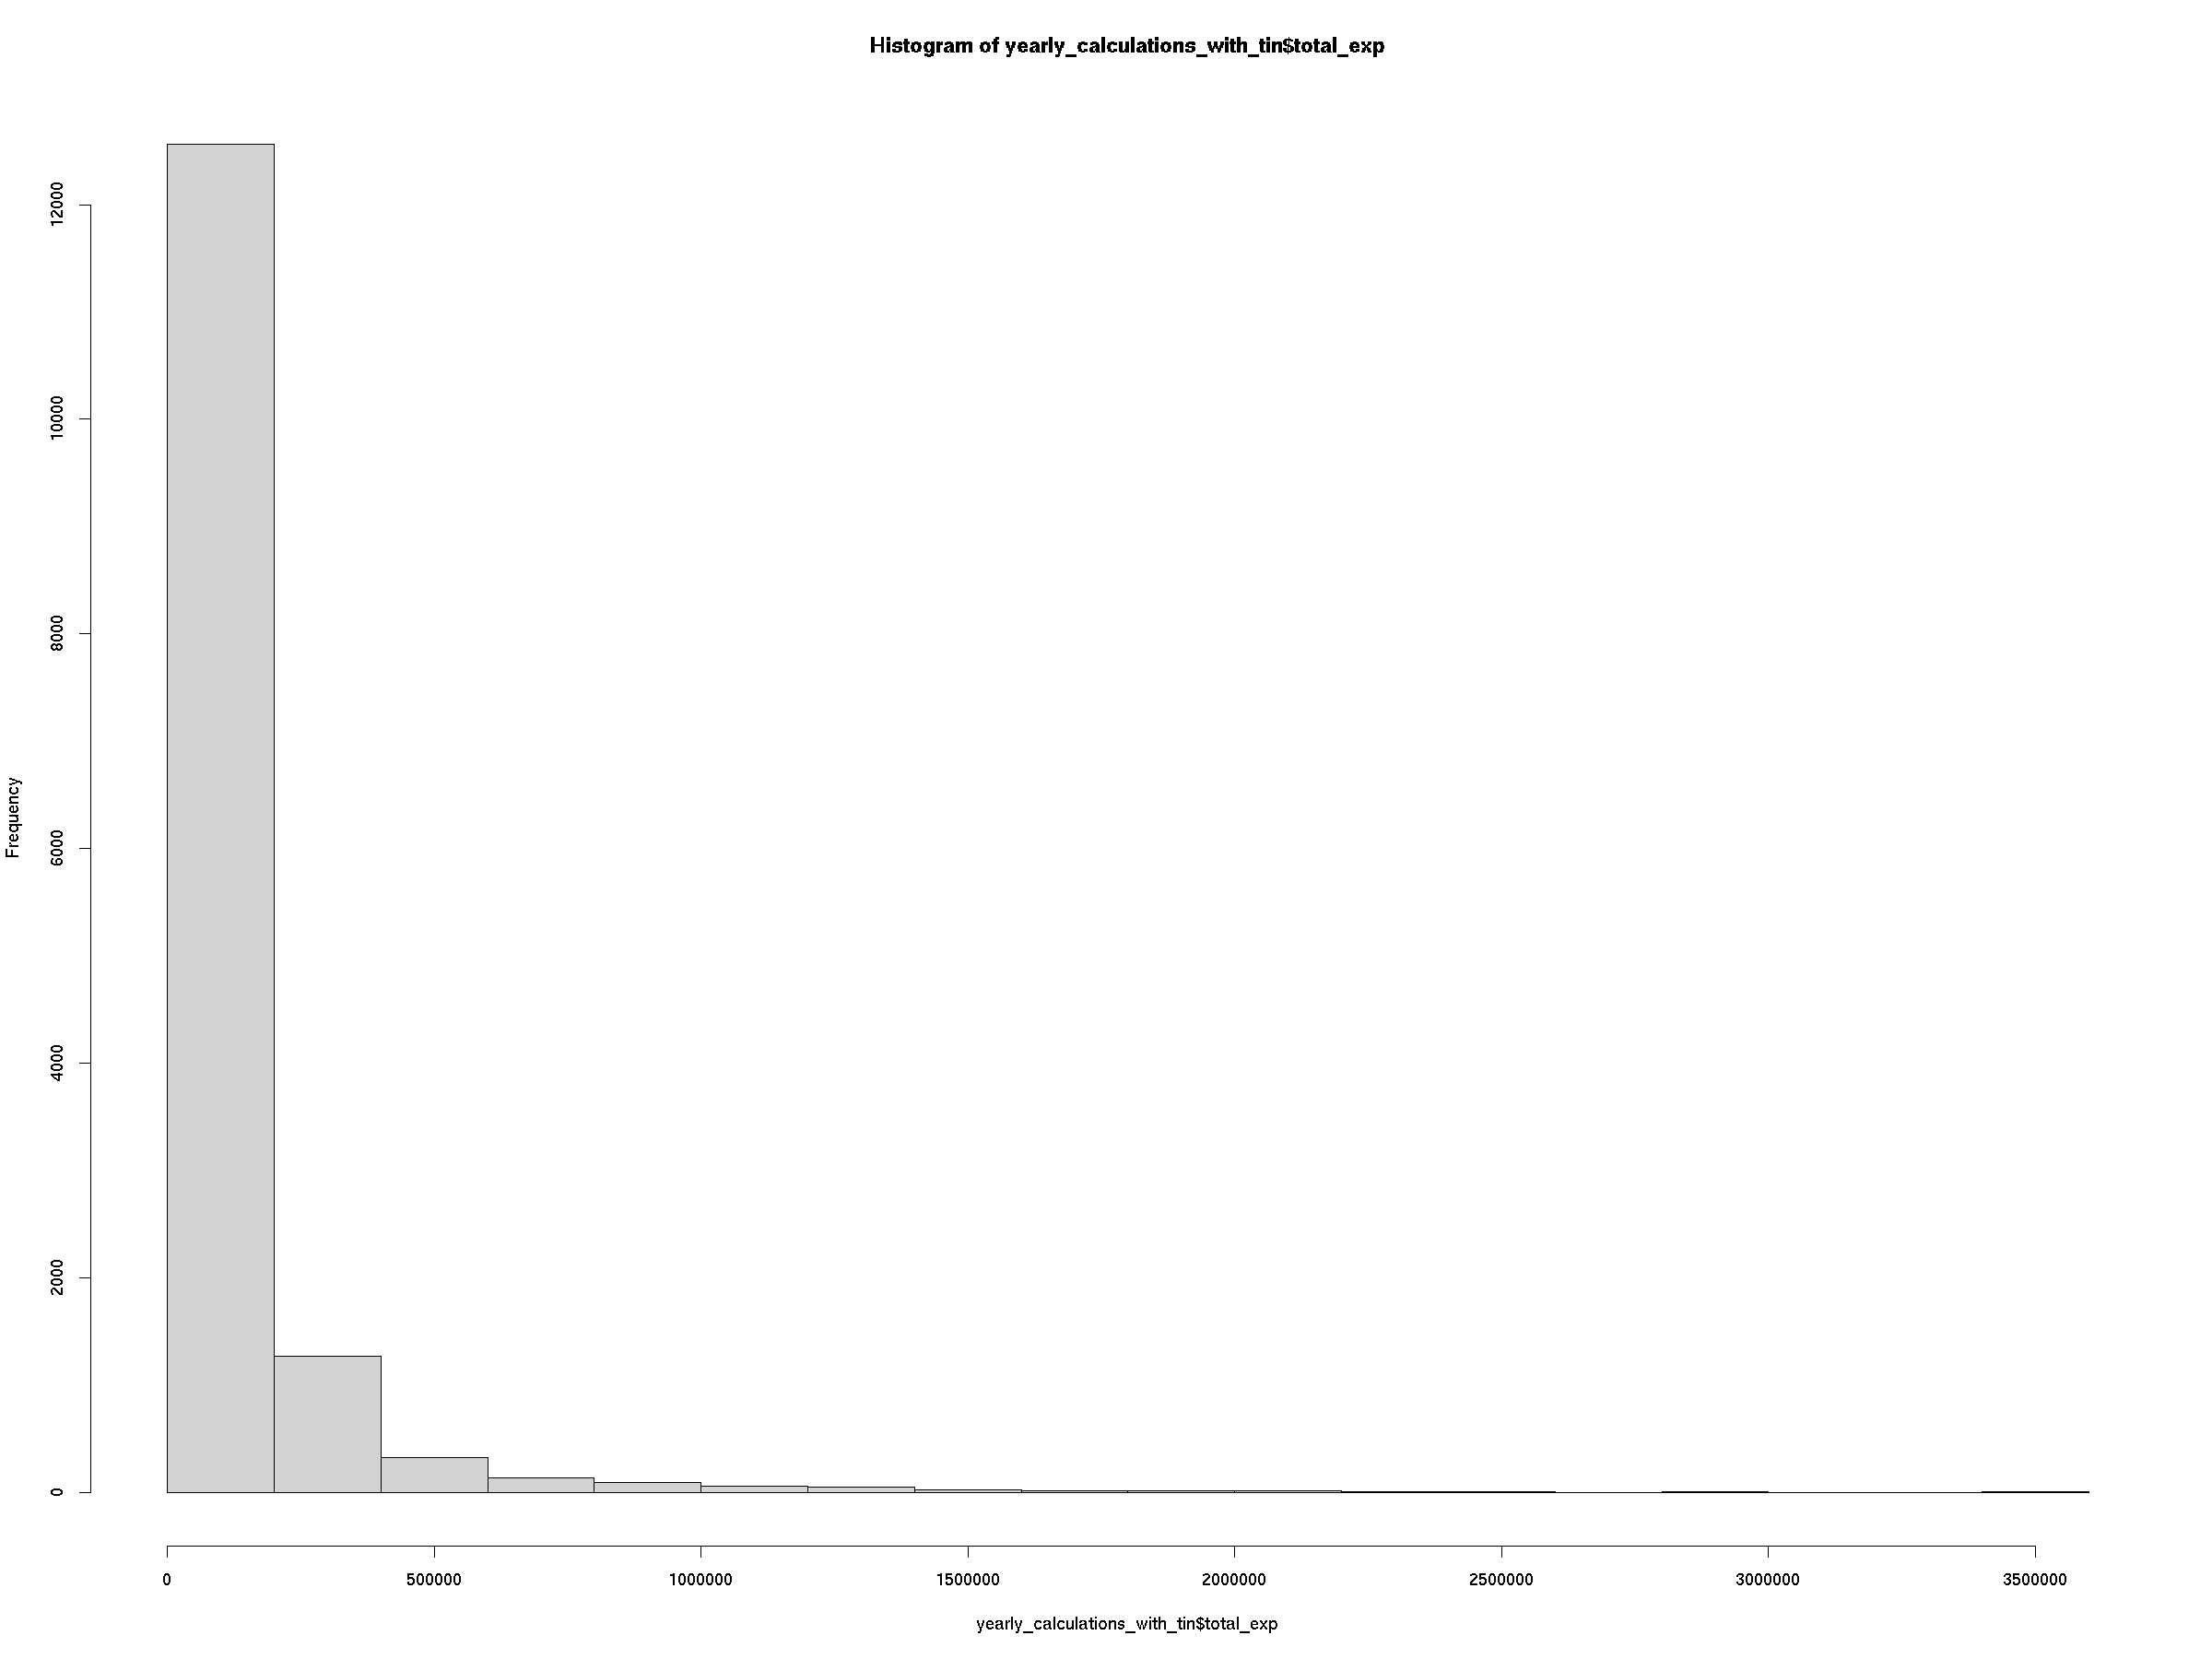

In [101]:
hist(yearly_calculations_with_tin$total_exp)

## Tests

In [105]:
intensity_comparator_t_test_averages=function(data){
  
  require(tidyverse)
  require(dtplyr)
  
  
      
  result=data%>%
    summarise(      
        t_test_total_exp=t.test(data=.,total_exp~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient=t.test(data=.,tot_allowed_inpatient~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient=t.test(data=.,tot_allowed_outpatient~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier=t.test(data=.,tot_allowed_carrier~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value, 
        t_test_total_exp_cardiology_related=t.test(data=.,total_exp_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_cardiology_related=t.test(data=.,tot_allowed_inpatient_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_cardiology_related=t.test(data=.,tot_allowed_outpatient_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_cardiology_related=t.test(data=.,tot_allowed_carrier_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value, 
        t_test_total_exp_same_tin=t.test(data=.,total_exp_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_same_tin=t.test(data=.,tot_allowed_inpatient_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_same_tin=t.test(data=.,tot_allowed_outpatient_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_same_tin=t.test(data=.,tot_allowed_carrier_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_total_exp_same_tin_cardiology_related=t.test(data=.,total_exp_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_same_tin_cardiology_related=t.test(data=.,tot_allowed_inpatient_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_same_tin_cardiology_related=t.test(data=.,tot_allowed_outpatient_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_same_tin_cardiology_related=t.test(data=.,tot_allowed_carrier_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_total_exp_not_same_tin=t.test(data=.,total_exp_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_not_same_tin=t.test(data=.,tot_allowed_inpatient_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_not_same_tin=t.test(data=.,tot_allowed_outpatient_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_not_same_tin=t.test(data=.,tot_allowed_carrier_not_same_tin~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_total_exp_not_same_tin_cardiology_related=t.test(data=.,total_exp_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_inpatient_not_same_tin_cardiology_related=t.test(data=.,tot_allowed_inpatient_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_outpatient_not_same_tin_cardiology_related=t.test(data=.,tot_allowed_outpatient_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value,
        t_test_tot_allowed_carrier_not_same_tin_cardiology_related=t.test(data=.,tot_allowed_carrier_not_same_tin_cardiology_related~most_common_cardiologist_integrated_in_year_of_diagnosis)$p.value
    )%>%
    as.data.table()
    
  return(result)
}

In [106]:
intensity_comparisons_t_test=intensity_comparator_t_test_averages(yearly_calculations_with_tin)
t(intensity_comparisons_t_test)

t_test_total_exp,9.400884e-02
t_test_tot_allowed_inpatient,1.210316e-01
t_test_tot_allowed_outpatient,5.447125e-01
t_test_tot_allowed_carrier,3.938575e-06
t_test_total_exp_cardiology_related,5.579329e-01
t_test_tot_allowed_inpatient_cardiology_related,8.801796e-01
t_test_tot_allowed_outpatient_cardiology_related,1.130218e-01
t_test_tot_allowed_carrier_cardiology_related,4.885447e-07
t_test_total_exp_same_tin,6.126446e-05
t_test_tot_allowed_inpatient_same_tin,9.666004e-03
t_test_tot_allowed_outpatient_same_tin,2.258271e-01
